In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim

# Import pprint, module we use for making our print statements prettier
import pprint
pp = pprint.PrettyPrinter()

### Ejercicio 1

Escribe código que cree un `torch.tensor` con los siguientes contenidos:
$\begin{bmatrix} 1 & 2.2 & 9.6 \\ 4 & -7.2 & 6.3 \end{bmatrix}$

Ahora calcule el promedio de cada fila (`.mean()`) y cada columna.

¿Cuál es la forma de los resultados?

In [27]:
t = torch.tensor([[1, 2.2, 9.6],[4, -7.2, 6.3]])
print("promedio de cada fila: ", t.mean(dim=1))
print("promedio de cada columna: ", t.mean(dim=0))

promedio de cada fila:  tensor([4.2667, 1.0333])
promedio de cada columna:  tensor([ 2.5000, -2.5000,  7.9500])


### Ejercicio 2

Escribe código que cree un `torch.tensor` con los siguientes contenidos:
$\begin{bmatrix} 1 & 2.2 & 9.6 \\ 4 & -7.2 & 6.3 \end{bmatrix}$

¿Cómo se obtiene la primera columna? ¿La primera fila?

In [28]:
print("primera columna: ", t[:,0])
print("primera fila: ", t[0,:])

primera columna:  tensor([1., 4.])
primera fila:  tensor([1.0000, 2.2000, 9.6000])


### Ejercicio 3

Cree una función vectorial (no lineal) en función de dos o tres vectores, determine sus derivadas respecto a cada componente de los vectores, para valores particulares, usando pytorch. Compruebe el resultado.

In [29]:
def f(v1, v2): return (v1*v2).sum()

In [30]:
v1 = torch.tensor([1., 2., 3.]).requires_grad_()
v2 = torch.tensor([3., 4., 5.]).requires_grad_()

y = f(v1, v2)

In [31]:
y.backward()
print('derivada respecto a v1: ', v1.grad)
print('derivada respecto a v2: ', v2.grad)

derivada respecto a v1:  tensor([3., 4., 5.])
derivada respecto a v2:  tensor([1., 2., 3.])


### Ejercicio 4

Use el dataset de `progressive-tweet-sentiment.csv` (el del taller 1), para producir una representación de vectores usando word2vec (máximo 50 vectores). Divida en un conjunto de entrenamiento y otro de prueba. A continuación, realice una clasificación de los tweets con un MLP (multilayer perceptron) de una capa oculta (tendrá que probar cuantas neuronas ocultas), usando como variables la media de los vectores de las palabras de cada tweet. Debe utilizar pytorch. Grafique el loss y el accuracy, tanto para el entrenamiento como para la validación. Escoja el mejor modelo probando con un buen número de epochs (use un learning rate de 0.1 o 0.01).


In [32]:
import pandas as pd
import numpy as np
from gensim.models.word2vec import Word2Vec 
import re
from unidecode import unidecode
from nltk import stem
from sklearn import preprocessing
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [33]:
df = pd.read_csv("data/progressive-tweet-sentiment.csv",encoding='latin-1')
df = df[["tweet", "target"]]
df.head()

,tweet,target
0,Thank you for another day of life Lord. #Chris...,Legalization of Abortion
1,@rosaryrevival Lovely to use Glorious Mysterie...,Legalization of Abortion
2,@Niall250 good thing is that #DUP have consist...,Legalization of Abortion
3,"So, you tell me... is murder okay if the victi...",Legalization of Abortion
4,@HillaryClinton Don't you mean to say (all chi...,Legalization of Abortion


In [34]:
# Encode label
le = preprocessing.LabelEncoder()
le.fit(df.target)
y = le.transform(df.target)
df['target'] = y
df.head()

,tweet,target
0,Thank you for another day of life Lord. #Chris...,3
1,@rosaryrevival Lovely to use Glorious Mysterie...,3
2,@Niall250 good thing is that #DUP have consist...,3
3,"So, you tell me... is murder okay if the victi...",3
4,@HillaryClinton Don't you mean to say (all chi...,3


### Word2Vec

In [35]:
def Preprocessing(d):
    # d -> document

    # Convert to lowercase every word  
    words = d.split()
    prep = [w.lower() for w in words]
    
    # Remove Spanish Stop Words
    prep = [w for w in prep if w not in ENGLISH_STOP_WORDS]
    if len(prep) == 0:
        return ''
    # Perform Unidecode normalization for removing accentuations, special characters etc.
    prep = [unidecode(w) for w in prep]

    # Remove special characters and punctuation
    prep = [re.sub('[^A-Za-z0-9]+', '', w) for w in prep]
    
    # Remove empty strings
    prep = [w for w in prep if w != '']
    
    # Lemmatization
    wnl = stem.WordNetLemmatizer()        
    prep = [wnl.lemmatize(w) for w in prep]
    
    
    processed_string = ' '.join(prep)
    return processed_string

In [36]:
def vectorized_tweet(model, tweet):
    vectorized_tweet = []
    for word in tweet:
        vectorized_tweet.append(model.wv.get_vector(word))
    return np.average(vectorized_tweet,axis=0)

In [37]:
def BuildWord2VecModel(corpus, vector_size, min_count, workers, sg, window, sample, random_seed):
    prep = [Preprocessing(d) for d in corpus]
    
    sentences = []
    for document in prep:
        sentences.append(document.split())
    Word2VecModel = Word2Vec(sentences=sentences, vector_size=vector_size, window=window, min_count=min_count, workers=workers, sg=sg, sample=sample,
            seed=random_seed)
    X = np.row_stack([vectorized_tweet(Word2VecModel, x) for x in sentences])      
    return X

### MLP

In [38]:
def BuildMLPModel(num_features, num_hidden, num_classes):
    MLPModel = nn.Sequential(
    nn.Linear(num_features,num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, num_classes)
    )

    return MLPModel

In [39]:
def loss_acc_batch(MLP_model, x, y, loss_func, acc = None):
    yp = MLP_model(x)
    yt = y.to().long() # .long() porque espera un entero tipo long
    loss = loss_func(yp, yt)
    out = [loss, len(x)]
    
    if acc is not None:
        y_pred = torch.argmax(MLP_model(x), 1) 
        accuracy = (y_pred == yt).float().mean().item()
        out.append(accuracy)
    return out

In [40]:
def train(MLPModel, NUM_EPOCHS, loss_func, train_dl, opt): 
    train_losses = []
    for epoch in range(NUM_EPOCHS):
        MLPModel.train() # importante para activar ciertas funciones como dropout, batchnormalization, etc.
        losses = 0
        nums = 0
        for x, y in train_dl:
            loss, l = loss_acc_batch(MLPModel, x, y, loss_func)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
            losses += loss.item() * l
            nums += l
        train_loss = losses / nums
        train_losses.append(train_loss)
        
        MLPModel.eval()  #importante para desactivar ciertas funciones como dropout, batchnormalization, etc.

    return train_losses

In [41]:
def valid(MLPModel, NUM_EPOCHS, loss_func, valid_dl):
    valid_losses = []
    valid_accs = []
    for epoch in range(NUM_EPOCHS):
        with torch.no_grad():
            losses, nums, accs = zip(*[loss_acc_batch(MLPModel, xb, yb, loss_func, acc=True) for xb, yb in valid_dl])
        losses = [l.item() for l in losses]
        valid_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)
        valid_losses.append(valid_loss)
        valid_acc = np.sum(np.multiply(accs,nums)) / np.sum(nums)    
        valid_accs.append(valid_acc)

    return valid_losses, valid_accs

### Build Word2Vec Model

In [42]:
corpus = df['tweet']
y = df['target']
y = np.asarray(y)
X = BuildWord2VecModel(corpus, vector_size=50, min_count=1, workers=20, sg=1, window=15, sample=1e-3, random_seed=42)
X.shape

(1159, 50)

In [43]:
# Train-Test Split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=1)
X_train, y_train, X_valid, y_valid = map(lambda x: torch.tensor(x, dtype=torch.float32),(X_train, y_train, X_valid, y_valid))

### Build MLP Model

In [44]:
RANDOM_SEED = 1
BATCH_SIZE = 64
NUM_EPOCHS = 100
lr = 0.01
torch.manual_seed(RANDOM_SEED)

train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_valid, y_valid)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size = 2*BATCH_SIZE)

num_features = 50 
num_hidden = 25
num_classes = len(torch.unique(y_train))

MLPModel = BuildMLPModel(num_features, num_hidden, num_classes)
loss_func = F.cross_entropy
opt = optim.SGD(MLPModel.parameters(), lr) # Optimizer function


In [45]:
train_losses = train(MLPModel, NUM_EPOCHS, loss_func, train_dl, opt)
valid_losses, valid_accs = valid(MLPModel, NUM_EPOCHS, loss_func, valid_dl)

epoch: 0,    train_loss: 1.3943             valid_loss: 1.3711, valid_acc: 0.2701
epoch: 10,    train_loss: 1.3836             valid_loss: 1.3711, valid_acc: 0.2701
epoch: 20,    train_loss: 1.3788             valid_loss: 1.3711, valid_acc: 0.2701
epoch: 30,    train_loss: 1.3767             valid_loss: 1.3711, valid_acc: 0.2701
epoch: 40,    train_loss: 1.3757             valid_loss: 1.3711, valid_acc: 0.2701
epoch: 50,    train_loss: 1.3751             valid_loss: 1.3711, valid_acc: 0.2701
epoch: 60,    train_loss: 1.3748             valid_loss: 1.3711, valid_acc: 0.2701
epoch: 70,    train_loss: 1.3746             valid_loss: 1.3711, valid_acc: 0.2701
epoch: 80,    train_loss: 1.3745             valid_loss: 1.3711, valid_acc: 0.2701
epoch: 90,    train_loss: 1.3744             valid_loss: 1.3711, valid_acc: 0.2701


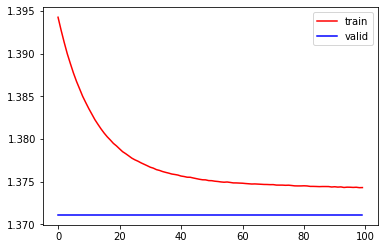

In [46]:
for epoch in range(NUM_EPOCHS):
    if epoch % 10 == 0:
            print(f"epoch: {epoch},    train_loss: {train_losses[epoch]:.4f} \
            valid_loss: {valid_losses[epoch]:.4f}, valid_acc: {valid_accs[epoch]:.4f}")
    
plt.plot(range(NUM_EPOCHS), train_losses, 'r', label='train')
plt.plot(range(NUM_EPOCHS), valid_losses, 'b', label = 'valid')
plt.legend()

Obtenemos un clasificador no tan bueno, pero sin embargo, es mejor que el clasificador aleatorio (mayor que 25% de las 4 clases)
Esto se debe a que solo contiene una capa oculta y es un modelo muy sencillo, y no es capaz de captar tanta información como lo fue el Random Forest usado en talleres previos. (Con 100 árboles de random forest).

-----

### Ejercicio 5
Este ejercicio, es más bien un tutorial de como realizar un clasificador de ventanas de palabras, acercandónos a un problema de NLP conocido como "Name entity recoginition" (NER), el cual busca clasificar cada palabra en por ejemplo si es un nombre, pronombre, verbo, lugar, etc. Esto es muy importante, porque introduce varias cuestiones claves que se usan en el NLP con deep learning. Al final, el ejercicio será (1) entender cada parte y (2) realizar el mismo procedimiento pero clasificando entre varios tipos de palabras (no sólo una). 

### Clasificación de ventanas de palabras (Word Window Classification) paso a paso

En esta tarea de NLP aprenderemos:

1. Datos: creación de un conjunto de datos de tensores por batches
2. Modelado
3. Entrenamiento
4. Predicción

En esta sección, nuestro objetivo será entrenar un modelo que encuentre las palabras en una oración correspondiente a una 'UBICACIÓN', que siempre tendrá un intervalo de '1' (lo que significa que 'San Francisco' no se reconocerá como un `UBICACIÓN`). Nuestra tarea se llama `Clasificación de ventana de palabras` por una razón. En lugar de permitir que nuestro modelo solo eche un vistazo a una palabra en cada paso hacia adelante, nos gustaría que pudiera considerar el contexto de la palabra en cuestión. Es decir, para cada palabra, queremos que nuestro modelo sea consciente de las palabras que lo rodean.

In [47]:
# Nuestros datos sin procesar, que consisten en oraciones
corpus = [
          "Nosotros siempre venimos a París",
          "El profesor es de Australia",
          "Yo vivo en Bogotá",
          "Él viene de Taiwán",
          "La capital de Turquía es Ankara"
         ]

#### Preprocesamiento

Para facilitar el aprendizaje de nuestros modelos, generalmente aplicamos algunos pasos de preprocesamiento a nuestros datos. Esto es especialmente importante cuando se trata de datos de texto. Estos son algunos ejemplos de preprocesamiento de texto:
* **Tokenización**: Tokenización de oraciones en palabras.
* **Lowercasing**: Cambiar todas las letras a minúsculas.
* **Eliminación de ruido**: Eliminación de caracteres especiales (como signos de puntuación o quitar tíldes).
* **Eliminación de palabras vacías**: eliminación de palabras de uso común.

Los pasos de preprocesamiento necesarios están determinados por la tarea en cuestión. Por ejemplo, aunque es útil eliminar caracteres especiales en algunas tareas, para otras pueden ser importantes (por ejemplo, si estamos hablando de varios idiomas). Para nuestra tarea, escribiremos en minúsculas nuestras palabras y tokenizaremos.

In [48]:
import re
from unicodedata import normalize
def quitartildes(s):
    # -> NFD y eliminar diacríticos
    s = re.sub(
            r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
            normalize( "NFD", s), 0, re.I
        )

    # -> NFC
    return normalize( 'NFC', s)

In [49]:
# La función de preprocesamiento que usaremos para generar nuestros ejemplos de entrenamiento
# Nuestra función es simple, ponemos las letras en minúsculas, quitamos tildes
# y luego tokenizamos las palabras.
def preprocess_sentence(sentence):
  return quitartildes(sentence).lower().split()

# Crea nuestro conjunto de entrenamiento
train_sentences = [preprocess_sentence(sent) for sent in corpus]
train_sentences

[['nosotros', 'siempre', 'venimos', 'a', 'paris'],
 ['el', 'profesor', 'es', 'de', 'australia'],
 ['yo', 'vivo', 'en', 'bogota'],
 ['el', 'viene', 'de', 'taiwan'],
 ['la', 'capital', 'de', 'turquia', 'es', 'ankara']]

Para cada ejemplo de entrenamiento que tengamos, también deberíamos tener una etiqueta correspondiente. Recuerde que el objetivo de nuestro modelo era determinar qué palabras corresponden a una `UBICACIÓN`. Es decir, queremos que nuestro modelo genere `0` para todas las palabras que no sean `UBICACION` y `1` para las que sean `UBICACION`.

In [50]:
# Set de ubicaciones que aparecen en el corpus
locations = set(["australia", "ankara", "paris", "bogota", "taiwan", "turquia"])

# Nuestras etiquetas de entrenamiento
train_labels = [[1 if word in locations else 0 for word in sent] for sent in train_sentences]
train_labels

[[0, 0, 0, 0, 1],
 [0, 0, 0, 0, 1],
 [0, 0, 0, 1],
 [0, 0, 0, 1],
 [0, 0, 0, 1, 0, 1]]

#### Convertir palabras a Embeddings

Veamos nuestros datos de entrenamiento un poco más de cerca. Cada punto de datos que tenemos es una secuencia de palabras. Por otro lado, sabemos que los modelos de aprendizaje automático funcionan con números en vectores. ¿Cómo vamos a convertir las palabras en números? ¡A través de los embeddings!

Imagine que tenemos una tabla de búsqueda de embeddings `E`, donde cada fila corresponde a un embedding. Es decir, cada palabra de nuestro vocabulario tendría una fila de embedding `i` correspondiente en esta tabla. Siempre que queramos encontrar una embedding para una palabra, seguiremos estos pasos:
1. Buscar el índice correspondiente `i` de la palabra en la tabla de embedding: `palabra->índice`.
2. Indexar en la tabla de embedding y obtener el embedding: `índice->embedding`.

Veamos el primer paso. Deberíamos asignar todas las palabras de nuestro vocabulario a un índice correspondiente. Podemos hacerlo de la siguiente manera:
1. Encontrando todas las palabras únicas en nuestro corpus.
2. Asignando un índice a cada uno.

In [51]:
# Encuentra todas las palabras únicas en nuestro corpus
vocabulary = set(w for s in train_sentences for w in s)
vocabulary

{'a',
 'ankara',
 'australia',
 'bogota',
 'capital',
 'de',
 'el',
 'en',
 'es',
 'la',
 'nosotros',
 'paris',
 'profesor',
 'siempre',
 'taiwan',
 'turquia',
 'venimos',
 'viene',
 'vivo',
 'yo'}

`vocabulary` ahora contiene todas las palabras en nuestro corpus. Por otro lado, durante la (evaluación con el conjunto de) prueba, podemos ver palabras que no están contenidas en nuestro vocabulario. Si podemos encontrar una forma de representar las palabras desconocidas, nuestro modelo aún podría razonar sobre si son una 'UBICACIÓN' o no, ya que también estamos mirando las palabras vecinas para cada predicción.

Introducimos un token especial, `<unk>`, para abordar las palabras que están fuera del vocabulario. Podríamos elegir otra cadena para nuestro token desconocido si quisiéramos. El único requisito aquí es que nuestro token debe ser único: solo debemos usar este token para palabras desconocidas. También agregaremos este token especial a nuestro vocabulario.

In [52]:
# Agrega el token desconocido a nuestro vocabulario
vocabulary.add("<unk>")

Anteriormente mencionamos que nuestra tarea se llamaba "Clasificación de ventana de palabras" porque nuestro modelo está mirando las palabras circundantes además de la palabra central, cuando se necesita hacer una predicción.

Por ejemplo, tomemos la oración "Nosotros siempre venimos a París". La etiqueta de entrenamiento correspondiente para esta oración es `0, 0, 0, 0, 1` ya que solo París, la última palabra, es una `UBICACIÓN`. En una sola pasada (es decir, una llamada a `forward()`), nuestro modelo intentará generar la etiqueta correcta para una palabra. Digamos que nuestro modelo intenta generar la etiqueta correcta `1` para `París`. Si solo permitimos que nuestro modelo vea `París`, pero nada más, nos perderemos información importante, como por ejemplo, de que la palabra 'a' aparece muchas veces con `UBICACIONES`.

Las ventanas de palabras permiten que nuestro modelo considere `+N` o `-N` palabras alrededor de cada palabra al hacer una predicción. En nuestro ejemplo anterior para `París`, si tenemos un tamaño de ventana de 1, eso significa que nuestro modelo mirará las palabras que vienen inmediatamente antes e inmediatamente después de `París`, que son `a` y, *ninguna palabra*. Ahora bien, esto plantea otro problema. `París` está al final de nuestra oración, por lo que no hay otra palabra que la siga. Recuerde que definimos las dimensiones de entrada de nuestros modelos en `PyTorch` cuando los inicializamos. Si establecemos el tamaño de la ventana en `1`, significa que nuestro modelo aceptará `3` palabras en cada paso. No podemos hacer que nuestro modelo espere `2` palabras de vez en cuando.

La solución es introducir un token especial, `<pad>`, que se agregará a nuestras oraciones para asegurarnos de que cada palabra tenga una ventana válida alrededor. Similar al token `<unk>`, podríamos elegir otra cadena para nuestro token de relleno si quisiéramos, siempre y cuando nos aseguremos de que se use para un propósito único.

In [53]:
# Agregua el token <pad> a nuestro vocabulario
vocabulary.add("<pad>")

# Función que rellena la oración dada
# Estamos introduciendo esta función aquí como un ejemplo
# Lo utilizaremos más adelante en el tutorial.
def pad_window(sentence, window_size, pad_token="<pad>"):
  window = [pad_token] * window_size
  return window + sentence + window

# Muestra un ejemplo de relleno
window_size = 2
pad_window(train_sentences[0], window_size=window_size)

['<pad>',
 '<pad>',
 'nosotros',
 'siempre',
 'venimos',
 'a',
 'paris',
 '<pad>',
 '<pad>']

Ahora que nuestro vocabulario está listo, asignemos un índice a cada una de nuestras palabras.

In [54]:
# Solo estamos convirtiendo nuestro vocabulario en una lista para poder indexarla
# Auunque ordenar no es necesario, ordenamos para mostrar un diccionario word_to_ind ordenado
# Dicho esto, veremos que tener el índice para el token de relleno
# como 0 es conveniente ya que algunas funciones de PyTorch lo usan como valor predeterminado
# como sucede con nn.utils.rnn.pad_sequence, que veremos en un momento
ix_to_word = sorted(list(vocabulary))

# Creando un diccionario para encontrar el índice de una palabra dada
word_to_ix = {word: ind for ind, word in enumerate(ix_to_word)}
word_to_ix

{'<pad>': 0,
 '<unk>': 1,
 'a': 2,
 'ankara': 3,
 'australia': 4,
 'bogota': 5,
 'capital': 6,
 'de': 7,
 'el': 8,
 'en': 9,
 'es': 10,
 'la': 11,
 'nosotros': 12,
 'paris': 13,
 'profesor': 14,
 'siempre': 15,
 'taiwan': 16,
 'turquia': 17,
 'venimos': 18,
 'viene': 19,
 'vivo': 20,
 'yo': 21}

In [55]:
ix_to_word[1]

'<unk>'

Ahora, estamos listos para convertir nuestras oraciones de entrenamiento en una secuencia de índices correspondientes a cada token.

In [95]:
# Dada una sentencia de tokens, devuelve los índices correspondientes
def convert_token_to_indices(sentence, word_to_ix):
  indices = []
  for token in sentence:
    # Comprueba si el token está en nuestro vocabulario. Si es así, obtiene su índice.
    # Si no, obtiene el índice del token desconocido.
    if token in word_to_ix:
      index = word_to_ix[token]
    else:
      index = word_to_ix["<unk>"]
    indices.append(index)
  return indices

# Versión más compacta de la misma función
def _convert_token_to_indices(sentence, word_to_ind):
  return [word_to_ind.get(token, word_to_ix["<unk>"]) for token in sentence]

# Muestra un ejemplo
example_sentence = ["nosotros", "siempre", "venimos", "a", "kuwait"]
example_indices = convert_token_to_indices(example_sentence, word_to_ix)
restored_example = [ix_to_word[ind] for ind in example_indices]

print(f"La oración original es: {example_sentence}")
print(f"Pasar de palabras a índices: {example_indices}")
print(f"Pasando de índices a palabras: {restored_example}")

La oración original es: ['nosotros', 'siempre', 'venimos', 'a', 'kuwait']
Pasar de palabras a índices: [1, 1, 1, 1, 1]
Pasando de índices a palabras: ['<unk>', '<unk>', '<unk>', '<unk>', '<unk>']


En el ejemplo anterior, `kuwait` aparece como `<unk>`, porque no está incluido en nuestro vocabulario. Convirtamos nuestras `train_sentences` a `example_padded_indices`.

In [57]:
# Convirtiendo nuestras sentencias a indices
example_padded_indices = [convert_token_to_indices(s, word_to_ix) for s in train_sentences]
example_padded_indices

[[12, 15, 18, 2, 13],
 [8, 14, 10, 7, 4],
 [21, 20, 9, 5],
 [8, 19, 7, 16],
 [11, 6, 7, 17, 10, 3]]

Ahora que tenemos un índice para cada palabra en nuestro vocabulario, podemos crear una tabla de embedding con la clase `nn.Embedding` de `PyTorch`. Se llama de la siguiente manera `nn.Embedding(num_words, embedding_dimension)` donde `num_words` es el número de palabras en nuestro vocabulario y `embedding_dimension` es la dimensión de los embeddings que queremos tener. No hay nada sofisticado en `nn.Embedding`: es solo una clase wrapper alrededor de un tensor dimensional entrenable de tamaño `NxE` , donde `N` es el número de palabras en nuestro vocabulario y `E` es el número de dimensiones incrustadas. Esta tabla es inicialmente aleatoria, pero cambiará con el tiempo. A medida que entrenamos nuestra red, los gradientes se propagarán hacia atrás hasta la capa de embedding y, por lo tanto, nuestros embeddings de palabras se actualizarán. Posteriormente, inicializaremos la capa de embedding que usaremos para nuestro modelo dentro de nuestro modelo, pero a continuación mostramos un ejemplo.

In [58]:
# Creando una tabla de embedding para nuestras palabras
embedding_dim = 5
embeds = nn.Embedding(len(vocabulary), embedding_dim)

# Imprimiendo los parámetros en nuestra tabla de embedding
list(embeds.parameters())

[Parameter containing:
 tensor([[ 9.1383e-01,  6.1150e-02,  1.1609e+00, -1.3764e+00, -9.2186e-02],
         [ 1.4949e-01, -1.0720e-02,  4.9850e-01, -1.8192e-01, -1.9860e-03],
         [-4.0665e-01,  4.7330e-01, -5.2607e-01, -5.0336e-01,  1.1941e-02],
         [ 2.0441e+00,  1.0085e+00, -1.0057e+00,  1.5166e+00,  7.9859e-02],
         [-7.2800e-01,  3.9660e-01, -1.0497e+00,  1.7139e+00, -1.9853e+00],
         [ 4.1897e-01, -8.0400e-02,  7.8269e-01, -1.5605e-01,  9.4288e-01],
         [-5.9307e-01, -4.8964e-01,  4.1848e-01, -1.0706e+00, -1.0111e-01],
         [ 3.0172e-01,  6.9667e-01, -1.1117e+00,  2.8073e-01,  2.7895e-01],
         [ 7.4957e-02, -8.8123e-01,  2.6913e-01,  9.4423e-01, -3.6116e-01],
         [-3.9219e-01,  5.0332e-01,  1.3764e+00, -5.6675e-01, -5.2636e-01],
         [ 7.6096e-01,  1.0038e+00,  2.0607e+00,  1.0247e+00,  3.4673e-01],
         [ 2.0862e+00, -5.7205e-01,  4.2380e-01, -1.0350e+00, -6.3797e-01],
         [ 1.1172e+00,  6.2899e-01,  6.4115e-01,  9.8201e-01,  9.

Para obtener el embedding de la palabra para una palabra en nuestro vocabulario, todo lo que tenemos que hacer es crear un tensor de búsqueda. El tensor de búsqueda es solo un tensor que contiene el índice que queremos buscar. La clase `nn.Embedding` espera un tensor de índices que sea del tipo `Long` Tensor, por lo que debemos crear nuestro tensor en consecuencia.

In [59]:
# Obtiene el embedding para la palabra paris
index = word_to_ix["paris"]
index_tensor = torch.tensor(index, dtype=torch.long)
paris_embed = embeds(index_tensor)
paris_embed

tensor([-1.5150,  0.2656,  0.1504,  0.1954, -0.2774],
       grad_fn=<EmbeddingBackward0>)

In [60]:
# También podemos obtener múltiples embeddings a la vez
index_paris = word_to_ix["paris"]
index_ankara = word_to_ix["ankara"]
indices = [index_paris, index_ankara]
indices_tensor = torch.tensor(indices, dtype=torch.long)
embeddings = embeds(indices_tensor)
embeddings

tensor([[-1.5150,  0.2656,  0.1504,  0.1954, -0.2774],
        [ 2.0441,  1.0085, -1.0057,  1.5166,  0.0799]],
       grad_fn=<EmbeddingBackward0>)

Por lo general, definimos la capa de embedding como parte de nuestro modelo, que veremos en las secciones posteriores de nuestro cuaderno.

#### Sentencias (frases) por batch
Esperar a que se procese todo nuestro corpus de entrenamiento antes de realizar una actualización (de los pesos) no es eficiente. Por otro lado, actualizar los parámetros después de cada ejemplo de entrenamiento hace que el *loss* sea menos estable entre actualizaciones. Para combatir estos problemas, actualizamos nuestros parámetros después de entrenar con un batch (lote o pedazo) de los datos. Esto nos permite obtener una mejor estimación del gradiente del *loss* global. En esta sección, aprenderemos cómo estructurar nuestros datos en batches usando la clase `torch.util.data.DataLoader`.

Llamaremos a la clase `DataLoader` de la siguiente manera: `DataLoader(data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)`. El parámetro `batch_size` determina el número de muestras por batch. En cada época, estaremos iterando sobre todos los batches usando el `DataLoader`. El orden de los batches es determinista por defecto, pero podemos pedirle a `DataLoader` que mezcle los batches configurando el parámetro `shuffle` en `True`. De esta manera nos aseguramos de no encontrarnos con un batch defectuoso varias veces.

Si se proporciona, `DataLoader` pasa los batches que prepara a `collate_fn`. Podemos escribir una función personalizada para pasar al parámetro `collate_fn` para imprimir estadísticas sobre nuestro batch o realizar un procesamiento adicional. En nuestro caso, usaremos `collate_fn` para:

1. Rellenar las ventanas de las sentencias de entrenamiento.
2. Conviertir las palabras las muestras de entrenamiento a índices.
3. Rellenar las muestras de entrenamiento para que todas las sentencias y etiquetas tengan la misma longitud. Del mismo modo, también necesitamos rellenar las etiquetas. Esto crea un problema puesto que al calcular el loss, necesitamos saber el número real de palabras en una muestra dada. También, realizaremos un seguimiento de este número en la función que le pasamos al parámetro `collate_fn`.

Debido a que nuestra versión de la función `collate_fn` necesitará acceder a nuestro diccionario `word_to_ix` (para que pueda convertir palabras en índices), haremos uso de la función `partial` de `Python`, que pasa los parámetros que le damos a la función que le pasamos.

In [61]:
from torch.utils.data import DataLoader
from functools import partial

def custom_collate_fn(batch, window_size, word_to_ix):
  # Divide nuestro batch en muestras de entrenamiento (x) y etiquetas (y)
  # Estamos convirtiendo nuestra x e y en tensores porque el método nn.utils.rnn.pad_secuence
  # espera tensores. Esto también es útil ya que nuestro modelo estará esperando tensores como
  # entradas.
  x, y = zip(*batch)

  # Ahora necesitamos rellenar las ventanas de nuestrass muestras de entrenamiento.
  # Ya hemos definido una función para manejar el relleno de la ventana. Lo incluimos aquí
  # de nuevo para que todo está en un solo lugar.
  def pad_window(sentence, window_size, pad_token="<pad>"):
    window = [pad_token] * window_size
    return window + sentence + window

  # Rellena las muestras de entrenamiento
  x = [pad_window(s, window_size=window_size) for s in x]

  # Ahora necesitamos convregistraremosertir las palabras de nuestras muestras de entrenamiento a índices.
  # Estamos copiando la función definida anteriormente por el mismo motivo anterior.
  def convert_tokens_to_indices(sentence, word_to_ix):
    return [word_to_ix.get(token, word_to_ix["<unk>"]) for token in sentence]

  # Convierte las muestras de entrenamiento a indices.
  x = [convert_tokens_to_indices(s, word_to_ix) for s in x]

  # Ahora rellenaremos las muestras para que las longitudes de todas las muestras en
  # un batch sean iguales, lo que permite realizar operaciones matriciales.
  # Establecemos el parámetro batch_first en True para que la matriz devuelta tenga
  # como la primera dimensión el batch.
  pad_token_ix = word_to_ix["<pad>"]


  # la función pad_sequence espera que la entrada sea un tensor, por lo que convertimos x en uno
  x = [torch.LongTensor(x_i) for x_i in x]
  x_padded = nn.utils.rnn.pad_sequence(x, batch_first=True, padding_value=pad_token_ix)

  # También rellenaremos las etiquetas. Antes de hacerlo, guardaremos el número
  # de etiquetas para que sepamos cuantas palabras existieron en cada ejemplo.
  lengths = [len(label) for label in y]
  lenghts = torch.LongTensor(lengths)

  y = [torch.LongTensor(y_i) for y_i in y]
  y_padded = nn.utils.rnn.pad_sequence(y, batch_first=True, padding_value=0)

  # Ahora estamos listos para devolver nuestras variables. El orden en que devolvemos
  #  nuestras variables coincidirá con el orden en que los leemos en nuestro ciclo de entrenamiento.
  return x_padded, y_padded, lenghts  

Esta función parece larga, pero realmente no tiene por qué serlo. Veamos una versión alternativa a continuación, en donde eliminamos las declaraciones y comentarios de funciones adicionales.

In [62]:
def _custom_collate_fn(batch, window_size, word_to_ix):
  # preparando los puntos de datos
  x, y = zip(*batch)  
  x = [pad_window(s, window_size=window_size) for s in x]
  x = [convert_tokens_to_indices(s, word_to_ix) for s in x]

  # rellena x tal que todas las muestras en el batch tengan el mismo tamano
  pad_token_ix = word_to_ix["<pad>"]
  x = [torch.LongTensor(x_i) for x_i in x]
  x_padded = nn.utils.rnn.pad_sequence(x, batch_first=True, padding_value=pad_token_ix)

  # Rellena "y" y guarda la longitud
  lengths = [len(label) for label in y]
  lenghts = torch.LongTensor(lengths)
  y = [torch.LongTensor(y_i) for y_i in y]
  y_padded = nn.utils.rnn.pad_sequence(y, batch_first=True, padding_value=0)

  return x_padded, y_padded, lenghts  

Ahora, podemos ver el `DataLoader` en acción.

In [63]:
# Parámetros a pasar al DataLoader
data = list(zip(train_sentences, train_labels))
batch_size = 2
shuffle = True
window_size = 2
collate_fn = partial(custom_collate_fn, window_size=window_size, word_to_ix=word_to_ix)

# Instancia el DataLoader
loader = DataLoader(data, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)

# Va a traves de un ciclo
counter = 0
for batched_x, batched_y, batched_lengths in loader:
  print(f"Iteration {counter}")
  print("Batched Input:")
  print(batched_x)
  print("Batched Labels:")
  print(batched_y)
  print("Batched Lengths:")
  print(batched_lengths)
  print("")
  counter += 1

Iteration 0
Batched Input:
tensor([[ 0,  0, 11,  6,  7, 17, 10,  3,  0,  0],
        [ 0,  0,  8, 19,  7, 16,  0,  0,  0,  0]])
Batched Labels:
tensor([[0, 0, 0, 1, 0, 1],
        [0, 0, 0, 1, 0, 0]])
Batched Lengths:
tensor([6, 4])

Iteration 1
Batched Input:
tensor([[ 0,  0, 12, 15, 18,  2, 13,  0,  0],
        [ 0,  0, 21, 20,  9,  5,  0,  0,  0]])
Batched Labels:
tensor([[0, 0, 0, 0, 1],
        [0, 0, 0, 1, 0]])
Batched Lengths:
tensor([5, 4])

Iteration 2
Batched Input:
tensor([[ 0,  0,  8, 14, 10,  7,  4,  0,  0]])
Batched Labels:
tensor([[0, 0, 0, 0, 1]])
Batched Lengths:
tensor([5])



Los tensores de entrada por batch que vimos antes se pasarán a nuestro modelo. Por otro lado, comenzamos diciendo que nuestro modelo será un clasificador de ventanas de palabras. Por la forma en que nuestros tensores de entrada están formateados actualmente, tenemos todas las palabras en una sentencia en un punto de datos. Cuando pasamos esta entrada a nuestro modelo, éste necesita crear las ventanas para cada palabra, hacer una predicción sobre si la palabra central es una `UBICACIÓN` o no, para cada ventana, juntar las predicciones y volver a hacerlo.

Podríamos evitar este problema si formateamos nuestros datos dividiéndolos en ventanas de antemano. En este ejemplo, en cambio, veremos cómo nuestro modelo se ocupa del formateo.

Dado que nuestro `window_size` es `N`, queremos que nuestro modelo haga una predicción sobre cada `2N+1` tokens. Es decir, si tenemos una entrada con `9` tokens y un `window_size` de `2`, queremos que nuestro modelo devuelva `5` predicciones. Esto tiene sentido porque antes de rellenarlo con `2` tokens en cada lado, nuestra entrada también tenía "5" tokens.

Podemos crear estas ventanas usando bucles for, pero hay una alternativa más rápida a `PyTorch`, que es el método `unfold(dimension, size, step)`. Podemos crear las ventanas que necesitamos usando este método de la siguiente manera:

In [64]:
# muestra el tensor original
print(f"Original Tensor: ")
print(batched_x)
print("")

# Crea los 2 * 2 + 1 chunkstrozos
chunk = batched_x.unfold(1, window_size*2 + 1, 1)
print(f"Windows: ")
print(chunk)

Original Tensor: 
tensor([[ 0,  0,  8, 14, 10,  7,  4,  0,  0]])

Windows: 
tensor([[[ 0,  0,  8, 14, 10],
         [ 0,  8, 14, 10,  7],
         [ 8, 14, 10,  7,  4],
         [14, 10,  7,  4,  0],
         [10,  7,  4,  0,  0]]])


### Modelo
Ahora que hemos preparado nuestro datos, estamos listos para construir nuestro modelo. Lo haremos a través de la creación de una clase que hereda de la clase `nn.Module` (ya lo hemos visto con la regresión logística y la MLP).

In [65]:
class WordWindowClassifier(nn.Module):

  def __init__(self, hyperparameters, vocab_size, pad_ix=0):
    super(WordWindowClassifier, self).__init__()
    
    """ Instancia las variabless """
    self.window_size = hyperparameters["window_size"]
    self.embed_dim = hyperparameters["embed_dim"]
    self.hidden_dim = hyperparameters["hidden_dim"]
    self.freeze_embeddings = hyperparameters["freeze_embeddings"]

    """ Capa de Embedding      
    Toma un tensor que contiene los índices de los embeddings y devuelve los embeddings
    correspondientes. La salida es de dimensión (número_de_índices * dimension_embedding).

     Si freeze_embeddings es True, configura los parámetros de la capa de embedding para que sean
     no entrenables. Esto es útil si solo queremos cambiar los parámetros que no sean de los embeddings.

    """
    self.embeds = nn.Embedding(vocab_size, self.embed_dim, padding_idx=pad_ix)
    if self.freeze_embeddings:
      self.embed_layer.weight.requires_grad = False

    """ Capa Oculta
    """
    full_window_size = 2 * window_size + 1
    self.hidden_layer = nn.Sequential(
      nn.Linear(full_window_size * self.embed_dim, self.hidden_dim), 
      nn.Tanh()
    )

    """ Caba de salida
    """
    self.output_layer = nn.Linear(self.hidden_dim, 1)

    """ Probabilidades 
    """
    self.probabilities = nn.Sigmoid()

  def forward(self, inputs):
    """
    Sea B:= batch_size
        L:= longitud de la ventana de la sentencia rellenada
        D:= self.embed_dim
        S:= self.window_size
        H:= self.hidden_dim
        
    entradas: un tensor (B, L) de los indices de los tokens
    """
    B, L = inputs.size()

    """
    Reshaping.
    Entra un tensor de tipo Long (B, L) 
    Produce un tensor de tipo Long (B, L~, S)
    """
    # Primero, obtiene las ventanas de palabras para cada palabra de entrada.
    token_windows = inputs.unfold(1, 2 * self.window_size + 1, 1)
    _, adjusted_length, _ = token_windows.size()

    # Es buena idea hacer verificaciones internas del tamaño de un tensor
    assert token_windows.size() == (B, adjusted_length, 2 * self.window_size + 1)

    """
    Embedding.
    Entra un torch.LongTensor de tamano (B, L~, S) 
    Produce un (B, L~, S, D) FloatTensor.
    """
    embedded_windows = self.embeds(token_windows)

    """
    Reshaping.
    Entra un (B, L~, S, D) FloatTensor.
    Cambia su tamano a (B, L~, S*D) FloatTensor.
    El argumento -1  "infiere" ser la última dimensión segun los ejes sobrantes.
    """
    embedded_windows = embedded_windows.view(B, adjusted_length, -1)

    """
    Capa 1.
    Entra un (B, L~, S*D) FloatTensor.
    Cambia su tamaño a un (B, L~, H) FloatTensor
    """
    layer_1 = self.hidden_layer(embedded_windows)

    """
    Capa 2
    Entra un (B, L~, H) FloatTensor.
    cambia su tamano a un (B, L~, 1) FloatTensor.
    """
    output = self.output_layer(layer_1)

    """
    Softmax.
    Entra un (B, L~, 1) FloatTensor de scores de clases no normalizados.
    Produce un (B, L~, 1) FloatTensor de scores de clases (log-)normalizados.
    """
    output = self.probabilities(output)
    output = output.view(B, -1)

    return output

### Entrenamiento

Ahora estamos listos para poner todo junto. Empecemos por preparar nuestros datos e inicializar nuestro modelo. Luego, podemos inicializar nuestro optimizador y definir nuestra función de loss. Esta vez, en lugar de usar una de las funciones de loss predefinidas, definiremos nuestra propia función de loss.

In [66]:
# Prepara los datos
data = list(zip(train_sentences, train_labels))
batch_size = 2
shuffle = True
window_size = 2
collate_fn = partial(custom_collate_fn, window_size=window_size, word_to_ix=word_to_ix)

# Instancia el dataloader
loader = DataLoader(data, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)

# Inicializa el modelo
# Es util colocar todos los hiperparamentros en un diccionario
model_hyperparameters = {
    "batch_size": 4,
    "window_size": 2,
    "embed_dim": 25,
    "hidden_dim": 25,
    "freeze_embeddings": False,
}

vocab_size = len(word_to_ix)
model = WordWindowClassifier(model_hyperparameters, vocab_size)

# define un optimizador
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Definir una función de pérdida, que calcula el binary cross entropy 
def loss_function(batch_outputs, batch_labels, batch_lengths):   
    # calcula el loss para todo el batch
    bceloss = nn.BCELoss()
    loss = bceloss(batch_outputs, batch_labels.float())

    # Reescala el loss. Recuerde que hemos utilizado longitudes para almacenar el
    # número de palabras en cada muestra de entrenamiento
    loss = loss / batch_lengths.sum().float()

    return loss

In [67]:
# Funcion que se llamara en cada epoch
def train_epoch(loss_function, optimizer, model, loader):
  
  # guarda el registro del loss para cada epoch
  total_loss = 0
  for batch_inputs, batch_labels, batch_lengths in loader:
    # limpia los gradientes
    optimizer.zero_grad()
    # corre un forward pass
    outputs = model.forward(batch_inputs)
    # calcula el loss para un batch
    loss = loss_function(outputs, batch_labels, batch_lengths)
    # Calcula los gradientes
    loss.backward()
    # Actualiza los parámetros
    optimizer.step()
    total_loss += loss.item()

  return total_loss


# Función que contiene el loop principal
def train(loss_function, optimizer, model, loader, num_epochs=10000):

  # Itera a traves de cada epoch y llama la funcion de train_epoch function
  for epoch in range(num_epochs):
    epoch_loss = train_epoch(loss_function, optimizer, model, loader)
    if epoch % 100 == 0: print(epoch_loss)

In [68]:
num_epochs = 1000
train(loss_function, optimizer, model, loader, num_epochs=num_epochs)

0.25828656554222107
0.21276957541704178
0.17929352447390556
0.14740975014865398
0.11378912255167961
0.09493086487054825
0.0689188577234745
0.05950475204735994
0.04277690965682268
0.04394833371043205


### Predicción

Veamos qué tan bien nuestro modelo hace predicciones. Podemos comenzar creando nuestros datos de prueba.

In [69]:
# Creando una sentencia de prueba
test_corpus = ["Ella viene de Paris"]
test_sentences = [s.lower().split() for s in test_corpus]
test_labels = [[0, 0, 0, 1]]

# Crea un dataloader de prueba
test_data = list(zip(test_sentences, test_labels))
batch_size = 1
shuffle = False
window_size = 2
collate_fn = partial(custom_collate_fn, window_size=2, word_to_ix=word_to_ix)
test_loader = torch.utils.data.DataLoader(test_data, 
                                           batch_size=1, 
                                           shuffle=False, 
                                           collate_fn=collate_fn)

In [70]:
for test_instance, labels, _ in test_loader:
  outputs = model.forward(test_instance)
  print(labels)
  print(outputs)

tensor([[0, 0, 0, 1]])
tensor([[0.1759, 0.0222, 0.0665, 0.9257]], grad_fn=<ViewBackward0>)


In [71]:
data

[(['nosotros', 'siempre', 'venimos', 'a', 'paris'], [0, 0, 0, 0, 1]),
 (['el', 'profesor', 'es', 'de', 'australia'], [0, 0, 0, 0, 1]),
 (['yo', 'vivo', 'en', 'bogota'], [0, 0, 0, 1]),
 (['el', 'viene', 'de', 'taiwan'], [0, 0, 0, 1]),
 (['la', 'capital', 'de', 'turquia', 'es', 'ankara'], [0, 0, 0, 1, 0, 1])]

### Ejercicio 
Cree unas frases con sus respectivas etiquetas para diferentes tipos de palabras: por ejemplo: nombre, verbo, lugar y otros, y realice un proceso simila al anterior donde clasificara las palabras usando ventanas.

In [102]:
corpus = [
          "Juan corre hacia el Parque",
          "Mi computador es hecho en China",
          "Adriana es Peruana, pero vive en México",
          "El presidente de Rusia Putin es complicado",
          "Colombia limita con Venezuela",
          "Barranquilla ciudad de cantores, Carlos"
         ]
train_sentences = [preprocess_sentence(sent) for sent in corpus]
train_sentences

[['juan', 'corre', 'hacia', 'el', 'parque'],
 ['mi', 'computador', 'es', 'hecho', 'en', 'china'],
 ['adriana', 'es', 'peruana,', 'pero', 'vive', 'en', 'mexico'],
 ['el', 'presidente', 'de', 'rusia', 'putin', 'es', 'complicado'],
 ['colombia', 'limita', 'con', 'venezuela'],
 ['barranquilla', 'ciudad', 'de', 'cantores,', 'carlos']]

In [125]:
# Set de ubicaciones que aparecen en el corpus
locations = set(["parque","china","mexico","rusia","colombia","venezuela","barranquilla"])
verbs = set(["corre","hecho","vive","limita"])
names = set(["juan","adriana","putin","carlos"])

def setLabel(w):
    if w in locations:
      return 1
    elif w in verbs:
      return 2
    elif w in names:
      return 3
    else:
      return 0

# Nuestras etiquetas de entrenamiento
# train_labels = [[setLabel(word) for word in sent] for sent in train_sentences]
train_labels = [[1 if word in verbs else 0 for word in sent] for sent in train_sentences]
train_labels

[[0, 1, 0, 0, 0],
 [0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0],
 [0, 0, 0, 0, 0]]

In [126]:
# Encuentra todas las palabras únicas en nuestro corpus
vocabulary = set(w for s in train_sentences for w in s)
vocabulary

{'adriana',
 'barranquilla',
 'cantores,',
 'carlos',
 'china',
 'ciudad',
 'colombia',
 'complicado',
 'computador',
 'con',
 'corre',
 'de',
 'el',
 'en',
 'es',
 'hacia',
 'hecho',
 'juan',
 'limita',
 'mexico',
 'mi',
 'parque',
 'pero',
 'peruana,',
 'presidente',
 'putin',
 'rusia',
 'venezuela',
 'vive'}

In [127]:
# Agrega el token desconocido a nuestro vocabulario
vocabulary.add("<unk>")
vocabulary.add("<pad>")

In [128]:
ix_to_word = sorted(list(vocabulary))
word_to_ix = {word: ind for ind, word in enumerate(ix_to_word)}
word_to_ix

{'<pad>': 0,
 '<unk>': 1,
 'adriana': 2,
 'barranquilla': 3,
 'cantores,': 4,
 'carlos': 5,
 'china': 6,
 'ciudad': 7,
 'colombia': 8,
 'complicado': 9,
 'computador': 10,
 'con': 11,
 'corre': 12,
 'de': 13,
 'el': 14,
 'en': 15,
 'es': 16,
 'hacia': 17,
 'hecho': 18,
 'juan': 19,
 'limita': 20,
 'mexico': 21,
 'mi': 22,
 'parque': 23,
 'pero': 24,
 'peruana,': 25,
 'presidente': 26,
 'putin': 27,
 'rusia': 28,
 'venezuela': 29,
 'vive': 30}

In [129]:
# Muestra un ejemplo
example_sentence = ["putin", "es", "ruso", "100", "de", "rusia"]
example_indices = _convert_token_to_indices(example_sentence, word_to_ix)
restored_example = [ix_to_word[ind] for ind in example_indices]

print(f"La oración original es: {example_sentence}")
print(f"Pasar de palabras a índices: {example_indices}")
print(f"Pasando de índices a palabras: {restored_example}")

La oración original es: ['putin', 'es', 'ruso', '100', 'de', 'rusia']
Pasar de palabras a índices: [27, 16, 1, 1, 13, 28]
Pasando de índices a palabras: ['putin', 'es', '<unk>', '<unk>', 'de', 'rusia']


In [130]:
# Creando una tabla de embedding para nuestras palabras
embedding_dim = 5
embeds = nn.Embedding(len(vocabulary), embedding_dim)

list(embeds.parameters())

[Parameter containing:
 tensor([[-1.2985,  1.3066, -1.2807, -0.3371,  2.1002],
         [ 1.2254, -0.9916,  1.7575,  0.6856,  2.1584],
         [-0.4914, -0.3957,  1.1853,  0.0220, -0.8884],
         [-1.8331, -0.1095,  0.8893,  1.2845,  0.0570],
         [-0.4806, -0.0053, -0.7067,  1.0979, -0.1631],
         [-0.7009,  1.3400,  0.4464,  0.4365, -0.9092],
         [ 0.2463,  0.6490,  0.3139,  0.4809, -1.0906],
         [ 0.8915, -0.9420,  0.7027, -0.2408, -0.3455],
         [ 0.3183, -1.0884, -0.1520,  0.0061, -0.3996],
         [ 0.8134, -0.9889,  0.4231, -0.8367,  0.4426],
         [-0.8154, -1.0136, -1.5503, -1.3388, -0.2976],
         [-0.3055,  3.1333,  0.0586,  1.4933,  0.1095],
         [-1.5897,  0.4866, -0.2785,  0.1751, -0.5630],
         [-1.7496, -0.2223,  1.2877,  0.3987,  0.5525],
         [ 0.7559,  1.6973,  0.4946,  0.7205,  0.5857],
         [-0.9268, -0.4616,  0.8920, -0.3574,  0.5745],
         [-0.0494, -0.0107, -2.0751,  2.0261,  1.2417],
         [-1.9695, -1.618

In [131]:
# Prepara los datos
data = list(zip(train_sentences, train_labels))
batch_size = 2
shuffle = True
window_size = 2
collate_fn = partial(custom_collate_fn, window_size=window_size, word_to_ix=word_to_ix)

# Instancia el dataloader
loader = DataLoader(data, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)

# Inicializa el modelo
# Es util colocar todos los hiperparamentros en un diccionario
model_hyperparameters = {
    "batch_size": 4,
    "window_size": 2,
    "embed_dim": 25,
    "hidden_dim": 25,
    "freeze_embeddings": False,
}

vocab_size = len(word_to_ix)
model = WordWindowClassifier(model_hyperparameters, vocab_size)

# define un optimizador
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)


In [132]:
num_epochs = 1000
train(loss_function, optimizer, model, loader, num_epochs=num_epochs)

0.19062365218997002
0.16541654244065285
0.14104698225855827
0.1242964081466198
0.10736460611224174
0.09063096158206463
0.07652974501252174
0.06827758811414242
0.05695875734090805
0.04895802401006222


In [139]:
# Creando una sentencia de prueba
test_corpus = ["Pedro esta hecho"]


test_sentences = [s.lower().split() for s in test_corpus]
test_labels = [[0, 0, 0, 3]]

# Crea un dataloader de prueba
test_data = list(zip(test_sentences, test_labels))
batch_size = 1
shuffle = False
window_size = 2
collate_fn = partial(custom_collate_fn, window_size=2, word_to_ix=word_to_ix)
test_loader = torch.utils.data.DataLoader(test_data, 
                                           batch_size=1, 
                                           shuffle=False, 
                                           collate_fn=collate_fn)

In [141]:
for test_instance, labels, _ in test_loader:
  outputs = model.forward(test_instance)
  print(labels)
  print(outputs)

tensor([[0, 0, 0, 3]])
tensor([[0.1066, 0.2675, 0.3460]], grad_fn=<ViewBackward0>)
